# Presidential Primaries! 

This data set is from 538's polling data for the 2020 Democratic Presidential Primary

In [29]:
import numpy as np
from SpringRank import SpringRank
# from itertools import chain
import matplotlib.pyplot as plt
from py import estimation
import pandas as pd
%matplotlib inline

In [30]:
# the hiring data itself

df = pd.read_csv('data/2020_democratic_primary/2020_primary_national_averages.csv')

df['modeldate'] = pd.to_datetime(df.modeldate)

names = np.unique(df.candidate_name)
lookup = {names[i] : i for i in range(len(names))}
r_lookup = {i : names[i] for i in range(len(names))}


t_begin = df.modeldate.min()

df['t'] = ((df.modeldate - t_begin)/np.timedelta64(1,'D')).astype(int)


df.head()

,modeldate,candidate_name,entrance,exit,mean_pct,t
0,2019-03-01,Amy Klobuchar,2019-03-01,2020-02-23,2.151013,0
1,2019-03-02,Amy Klobuchar,2019-03-01,2020-02-23,2.152732,1
2,2019-03-03,Amy Klobuchar,2019-03-01,2020-02-23,2.152732,2
3,2019-03-04,Amy Klobuchar,2019-03-01,2020-02-23,2.252959,3
4,2019-03-05,Amy Klobuchar,2019-03-01,2020-02-23,2.330338,4


The next step is to transform the data into a sequence of cumulative matrices

In [31]:
# primary data transformation: here be bugs??

n = len(names)

t_min = df.t.min()
t_max = df.t.max()

T_ = np.zeros((t_max-t_min+1, n, n))
for i in df.index:
    T_[df.t[i], lookup[df.candidate_name[i]], :] += df.mean_pct[i] 
T = np.cumsum(T_, axis = 0)

In [32]:
# Let's start t_start years in
t_start = 0

A0 = T[t_start,:,:]
A0 = A0 / A0.sum() # normalized

# mean hiring per year after t_start: 
v = T[t_start:,:,:].sum(axis = (1,2))
A0 = A0*((v[-1] - v[0]) / len(v))

Next, we'll try to learn the parameters from the data. 

In [33]:
lam_grid = 101 # resolution in $\lambda$
b_grid = 101   # resolution in $\beta$

LAMBDA = np.linspace(-1, 1, lam_grid) # lambda values at which to evaluate
BETA = np.linspace(1, 5, b_grid)            # beta values at which to evaluate

# compute the likelihood at each combination of lambda and beta. 
# might take a little while depending on lam_grid, beta_grid, n, and n_rounds

M = estimation.likelihood_surface(T, LAMBDA, BETA, A0) 

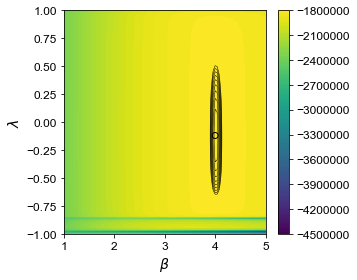

In [34]:
fig = plt.figure(figsize = (5,4))
ax = fig.add_subplot(111)

xg, yg = np.meshgrid(BETA, LAMBDA)

im = ax.contourf(xg, yg, M, levels = 100)
ax.contour(xg, yg, M, 
           levels = np.linspace(M.max()-500, 
                                M.max(), 10), 
           linewidths = .5, 
           colors = 'black', 
           linestyles = 'solid')

plt.colorbar(im)

ax.set(xlabel = r'$\beta$',
       ylabel = r'$\lambda$')

ix = np.where(M == M.max())
beta_hat = BETA[ix[1]][0]
lambda_hat = LAMBDA[ix[0]][0]

ax.scatter(beta_hat, lambda_hat, color = 'black', facecolor = 'None')

plt.tight_layout()

In [35]:
# the estimates are: 
ix = np.where(M == M.max())
beta_hat = BETA[ix[1]][0]
lambda_hat = LAMBDA[ix[0]][0]
beta_hat, lambda_hat

(4.0, -0.12)

In [36]:
stderrs = np.sqrt(-np.diag(np.linalg.inv(estimation.hessian(M, BETA, LAMBDA)[ix])[0]))
stderrs

array([0.04678428, 0.00182583])

# Time-Series Visualization

Now that we have plausible(??) values for $\lambda$ and $\beta$, we can visualize time-series of $\gamma$.

In [37]:
T_ = T[t_start:,:,:]

years = np.arange(df.t.min() + t_start, df.t.max()+1)
lam = -lambda_hat
n_rounds = T_.shape[0]
beta = beta_hat

# def plot_gammas(T, lam, title = '', figsize = (5,4)):
A = estimation.state_matrix(T_, lam, A0) # check in on this state matrix computation, seems off
GAMMA = np.zeros((n_rounds, n))
for k in range(n_rounds):
    GAMMA[k] = estimation.compute_gamma(A[k], beta)
    
top_trajectories = np.unique(GAMMA.argmax(axis = 1))
top_trajectories = (-GAMMA.mean(axis = 0)).argsort()[0:6]

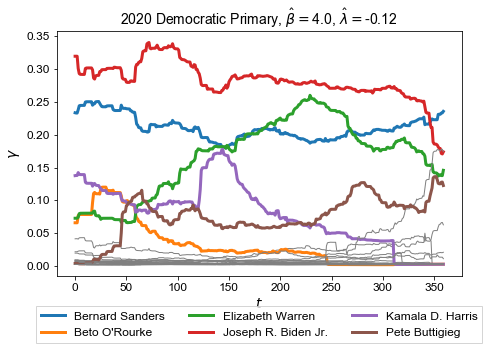

In [38]:
fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot(111)

k = 0
for l in range(n):
    if l in top_trajectories: 
        ax.plot(years, GAMMA[:,l], alpha = 1, linewidth = 3, label = r_lookup[l])
        k += 1
    else:
        ax.plot(years, GAMMA[:,l], color = 'grey', alpha = 1, linewidth = 1)

        
    ax.set(xlabel = r'$t$',
       ylabel = r'$\gamma$', 
       title = r'2020 Democratic Primary, $\hat{\beta} = $' + str(round(beta_hat, 2)) + r', $\hat{\lambda} = $' + str(round(lambda_hat, 2)))

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=False, shadow=False, ncol=3)

plt.tight_layout()

# Comparison of several measures

In [39]:
# s = SpringRank.SpringRank(T[-1])

all_names = [r_lookup[v] for v in range(n)]
gamma_from_aggregate = estimation.compute_gamma(T[-1], beta = beta_hat)
mean_gamma = GAMMA.mean(axis = 0)
gamma_most_recent = GAMMA[-1]

# all_names
# mean_gamma


df = pd.DataFrame(
{
    'name': all_names,
    'aggregate_score' : gamma_from_aggregate,
    'mean_gamma' : mean_gamma,
    'most_recent' : gamma_most_recent
})

df.sort_values(by = ['most_recent'], ascending = False).head(10)

,name,aggregate_score,mean_gamma,most_recent
2,Bernard Sanders,0.216799,0.210598,0.235460
18,Michael Bloomberg,0.025709,0.028882,0.174246
13,Joseph R. Biden Jr.,0.290107,0.282064,0.173845
7,Elizabeth Warren,0.178169,0.166282,0.145761
21,Pete Buttigieg,0.074411,0.074563,0.122593
0,Amy Klobuchar,0.015370,0.016951,0.062787
25,Tom Steyer,0.005523,0.006969,0.020988
26,Tulsi Gabbard,0.008374,0.009119,0.011225
1,Andrew Yang,0.017031,0.019130,0.002794
6,Deval Patrick,0.006154,0.006758,0.002794


# A prettier version

The code below just takes these two plots and combines them into a single figure, with some cosmetics. 

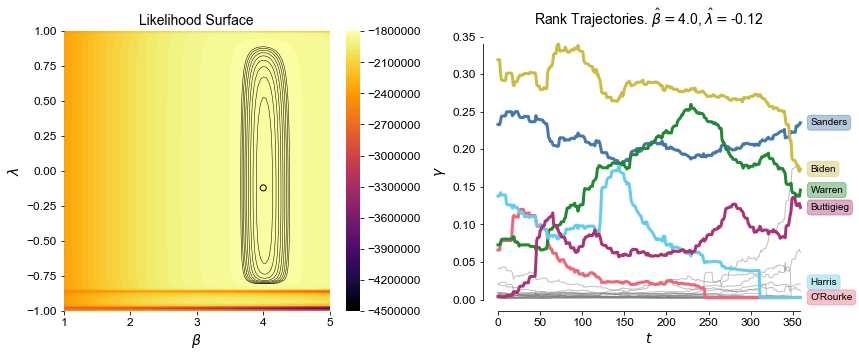

In [40]:
import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial Unicode MS"

SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


fig = plt.figure(figsize = (12,5))

ax1 = fig.add_subplot(121)
xg, yg = np.meshgrid(BETA, LAMBDA)

im = ax1.contourf(xg, yg, M, levels = 100, cmap = 'inferno')
ax1.contour(xg, yg, M, 
           levels = np.linspace(M.max()-5000, 
                                M.max(), 10), 
           linewidths = .5, 
           colors = 'black', 
           linestyles = 'solid')

cb = plt.colorbar(im)
cb.outline.set_visible(False)

#     ax.scatter(beta, lam, color = 'black')

ax1.set(xlabel = r'$\beta$',
       ylabel = r'$\lambda$',
       title = 'Likelihood Surface')

ix = np.where(M == M.max())
beta_hat = BETA[ix[1]][0]
lambda_hat = LAMBDA[ix[0]][0]

ax1.scatter(beta_hat, lambda_hat, color = 'black', facecolor = 'None')

for pos in ['top', 'right', 'left', 'bottom']: 
    ax1.spines[pos].set_visible(False)

ax2 = fig.add_subplot(122)

shortener = {
    'Bernard Sanders' : 'Sanders',
    'Elizabeth Warren' : 'Warren', 
    'Joseph R. Biden Jr.' : 'Biden',
    "Beto O'Rourke" : "O'Rourke",
    'Pete Buttigieg' : 'Buttigieg',
    'Kamala D. Harris' : 'Harris',
    'The University of Chicago' : 'Chicago'
}

cset = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377']

label_adjustments = {
    'Sanders': 0.000,
    'Warren' : 0,
    'Biden': -0.000,
    "O'Rourke" : 0.00,
    'Buttigieg' : 0,
    'Harris' : 0.02
}

k = 0

for l in range(n):
    if l not in top_trajectories:
        ax2.plot(years, GAMMA[:,l], color = 'grey', alpha = .5, linewidth = 1)

for l in range(n):
    if l in top_trajectories: 
        name = shortener[r_lookup[l]]
        ax2.plot(years, GAMMA[:,l], alpha = 1, linewidth = 3, 
                 label = name, color = cset[k])
        
        ax2.annotate(shortener[r_lookup[l]],
                  xy=(years.max(), GAMMA[-1:,l] + label_adjustments[name]), xycoords='data',
                  xytext=(10, 0), textcoords='offset points',
                  size=10, va="center", color = 'black',
                  bbox=dict(boxstyle="round",  color = cset[k], alpha = .4))
        
        
        k += 1
        
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_bounds(0, GAMMA.max())
ax2.spines['bottom'].set_bounds(years.min(), years.max())

ax2.set(xlabel = r'$t$',
       ylabel = r'$\gamma$', 
       title = r'Rank Trajectories. $\hat{\beta} = $' + str(round(beta_hat, 2)) + r', $\hat{\lambda} = $' + str(round(lambda_hat, 2)))

# ax2.legend(loc='upper center', bbox_to_anchor=(1.1, 0.7),
#           fancybox=False, shadow=False, ncol=1, frameon = False)

# fig.suptitle('Math PhD Exchange', fontsize = 16)

plt.tight_layout()

plt.savefig('fig/2020_democratic_primary.png', dpi = 300, bbox_inches = 'tight')

In [41]:
stderrs = np.sqrt(-np.diag(np.linalg.inv(estimation.hessian(M, BETA, LAMBDA)[ix])[0]))